In [1]:
import faiss
import os
import pandas as pd
from pprint import pprint
from sentence_transformers import SentenceTransformer


names = ['all-miniLM-L6-v2', 'bge-base-en-v1.5', 'e5-base-v2', 'instructor-base']

def load_model(model_name: str) -> SentenceTransformer:
    """Load a SentenceTransformer model by name."""
    if model_name == 'all-miniLM-L6-v2':
        model_name = 'sentence-transformers/all-miniLM-L6-v2'
    elif model_name == 'bge-base-en-v1.5':
        model_name = 'BAAI/bge-base-en-v1.5'
    elif model_name == 'e5-base-v2':
        model_name = 'intfloat/e5-base-v2'
    elif model_name == 'instructor-base':
        model_name = 'hkunlp/instructor-base'

    return SentenceTransformer(model_name, device='cuda')

c:\Users\Admin\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Build FAISS Index
Create a FAISS index for efficient similarity search

In [2]:
def create_embeddings(model, text_list):
    embeddings = model.encode(text_list, convert_to_numpy=True, show_progress_bar=True, batch_size=16)
    return embeddings

def get_faiss_index(name: str, load_model_ = False):
    """Returns the FAISS index, texts, and embedding dimension for the specified model name."""
    
    save_path = f'../Data/FAISSINDEX/{name}.bin'
    model = None
    
    if os.path.exists(save_path):
        index = faiss.read_index(save_path)
        print(f"FAISS index loaded from {save_path} with {index.ntotal} vectors.")
        dataset = pd.read_excel(f'../Data/{name}_dataset.xlsx')
        text1 = dataset.text1
        text2 = dataset.text2[dataset.text2.notnull()]
        texts = pd.concat([text1, text2]).tolist()
        dimension = index.d
        if load_model:
            model = load_model(name)
        return index, texts, dimension, model

    dataset = pd.read_excel(f'../Data/{name}_dataset.xlsx')
    text1 = dataset.text1
    text2 = dataset.text2[dataset.text2.notnull()]
    texts = pd.concat([text1, text2]).tolist() 

    model = load_model(name)
    embeddings = create_embeddings(model, texts)
    dimension = embeddings.shape[1]
    
    index = faiss.IndexFlatIP(dimension)
    faiss.normalize_L2(embeddings)
    index.add(embeddings)

    print(f"FAISS index created for model: {name} with {index.ntotal} vectors.")

    if not os.path.exists('Data/FAISSINDEX'):
        os.makedirs('Data/FAISSINDEX')

    faiss.write_index(index, save_path)
    print(f"FAISS index saved to {save_path}")

    return index, texts, dimension, model

In [12]:
import pandas as pd

data = pd.read_excel('../Evaluation/FAISS/Deduplication dataset/bge-base-en-v1.5.xlsx')

In [13]:
len(data)

72416

In [2]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('BAAI/bge-base-en-v1.5', device='cuda')

c:\Users\Admin\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Test Similarity Search
Search for similar texts using a query

In [4]:
# Function to search for similar texts
def search_similar_texts(model, index, texts, query, k=5):
    """
    Search for k most similar texts to the query
    
    Args:
        query: Query text string
        k: Number of similar results to return
    
    Returns:
        DataFrame with similar texts and their distances
    """
    # Encode the query
    query_embedding = model.encode([query], convert_to_numpy=True)
    
    # Search the index
    distances, indices = index.search(query_embedding, k)
    
    # Create results dataframe
    results = pd.DataFrame({
        'rank': range(1, k+1),
        'text': [texts[idx] for idx in indices[0]],
        'distance': distances[0],
        'index': indices[0]
    })
    
    return results

## Save FAISS Index (Optional)
Save the index and embeddings for later use

In [3]:
indexes = {}
for name in names:
    index, texts, dimension, model = get_faiss_index(name, load_model_=False)
    indexes[name] = {
        'index': index,
        'texts': texts,
        'dimension': dimension,
        'model': model
    }

FAISS index loaded from ../Data/FAISSINDEX/all-miniLM-L6-v2.bin with 123565 vectors.
FAISS index loaded from ../Data/FAISSINDEX/bge-base-en-v1.5.bin with 115254 vectors.
FAISS index loaded from ../Data/FAISSINDEX/e5-base-v2.bin with 115254 vectors.
FAISS index loaded from ../Data/FAISSINDEX/instructor-base.bin with 116245 vectors.


### Key benchmark is on the ground truth samples

Evaluate with difference tolerance: 1, 3, 5.
We have only 7085 rows of true duplicate samples, so we have to test on those for accuracy.

Clustering based evaluation can be performed on the negative samples

In [54]:
# Mapping for the values
tolerances = [1, 3, 5, 10]

name = 'e5-base-v2'
index, texts, dimension, model = indexes[name].values()

dataset = pd.read_excel(f'../Data/{name}_dataset.xlsx')

start1 = dataset[dataset.text2.notnull()].index[0]
start2 = len(dataset)
indices = dataset[dataset.is_duplicate.apply(lambda x: True if x > 0 else False)].index


texts[start1 + 6], texts[start2 + 6]

('Which are the best books to read on Digital Marketing?',
 'What are some good books on Digital marketing?')

In [16]:
"""Only accuracy is considered, since precision and recall is not applicable if there are no classes"""
from tqdm import tqdm

save_path = f"Evaluation/FAISS/{name}.json"

results = {}

for tolerance in tolerances:
    total = 0
    correct = 0
    for idx in tqdm(indices, desc=f"Evaluating tolerance {tolerance}"):
        query = texts[idx]
        result = search_similar_texts(model, index, texts, query, k=tolerance + 1)
        if idx - start1 + start2 in result['index'].values:
            correct += 1
        total += 1
    accuracy = correct / total
    # recall = correct / len(indices)
    # precision = correct / (total * tolerance)
    results[f'tolerance_{tolerance}'] = {
        'total': total,
        'correct': correct,
        'accuracy': accuracy,
    }
    pprint(results)

Evaluating tolerance 1:   0%|          | 0/7085 [00:00<?, ?it/s]


NameError: name 'search_similar_texts' is not defined

In [ ]:
import json
with open(save_path, 'w') as f:
    json.dump(results, f, indent=4)

### Perform text deduplication
- Option:
    - Using some consine similarity threshold

Save the data as a pandas dataframe.

In [55]:
import numpy as np
import psutil
import os

def deduplicate_texts_with_mapping(model, index, texts, threshold=0.9):
    """
    Deduplicate texts using FAISS index and cosine similarity threshold.
    Returns:
        unique_texts: list of unique texts
        mapping: dict {unique_index: [represented_indices]}
        total_time: execution time in seconds
        total_count: total number of texts
        peak_memory_mb: peak memory usage in MB
    """
    from tqdm import tqdm
    import time

    # Get current process
    process = psutil.Process(os.getpid())
    
    # Record initial memory
    initial_memory = process.memory_info().rss / 1024 / 1024  # MB
    peak_memory = initial_memory
    
    unique_indices = []
    seen = set()
    mapping = {}
    total_count = len(texts)
    start_time = time.time()
    
    for i, text in tqdm(enumerate(texts), total=len(texts), desc="Deduplicating"):
        if i in seen:
            continue
        
        # Track peak memory periodically (every 100 iterations to reduce overhead)
        if i % 100 == 0:
            current_memory = process.memory_info().rss / 1024 / 1024
            peak_memory = max(peak_memory, current_memory)
        
        query_embedding = model.encode([text], convert_to_numpy=True)
        distances, indices_ = index.search(query_embedding, 500)
        group = [i]
        for dist, idx in zip(distances[0], indices_[0]):
            if idx != i:
                if dist > threshold:
                    seen.add(int(idx))
                    group.append(int(idx))
                else: break
        else:
            print("All index checked there might be even more duplicates")
        unique_indices.append(i)
        mapping[i] = group
    
    # Final memory check
    final_memory = process.memory_info().rss / 1024 / 1024
    peak_memory = max(peak_memory, final_memory)
    
    total_time = time.time() - start_time
    unique_texts = [texts[i] for i in unique_indices]
    
    memory_used = peak_memory - initial_memory
    
    print(f"\nMemory Stats:")
    print(f"  Initial: {initial_memory:.2f} MB")
    print(f"  Peak: {peak_memory:.2f} MB")
    print(f"  Used: {memory_used:.2f} MB")
    
    return unique_texts, unique_indices, mapping, total_time, total_count, peak_memory

In [56]:
name

'e5-base-v2'

In [57]:
index, texts, dimension, model = indexes[name].values()
unique_texts, unique_indices, mapping, total_time, total_count, peak_memory = deduplicate_texts_with_mapping(model, index, texts, threshold=0.9)

Deduplicating:   0%|          | 0/115254 [00:00<?, ?it/s]

Deduplicating: 100%|██████████| 115254/115254 [1:14:43<00:00, 25.71it/s] 


Memory Stats:
  Initial: 1049.62 MB
  Peak: 2306.43 MB
  Used: 1256.81 MB


In [58]:
total_time, total_count

(4483.479178905487, 115254)

In [22]:
D, I = index.search(model.encode([texts[1200]], convert_to_numpy=True), 10)
for idx in I[0]:
    print(texts[idx])


D, I

We bought this thermometer a couple of years ago. Time to replace it. Not bad for a temporary outdoor temperature solution, but its rusted and then just starting falling apart. If you plan on buying a thermometer every couple of years, this is the one for you.
We have used this since last summer and it has been getting really rusty. It is covered in the winter time so you would think it would not get that bad but it has been. It has been staining our patio with rust spots. Not too thrilled about that
I got it a couple of years ago, and now have to replace - it rusted through.Well made and easy to use - until its stainless steel qualities are gone.
I purchased this thermometer, put it away for a few months, pulled it out to make some candy... It worked (showed the temperature) until it was attached to the saucepan. Why did it stop working? The pivoting feature caused the wire to the temperature probe to shear off. Since it is severed at the point where it enters the probe there is not e

(array([[1.0000001 , 0.76167154, 0.75674903, 0.73040724, 0.7259325 ,
         0.72181547, 0.7213485 , 0.7212856 , 0.7186242 , 0.7128228 ]],
       dtype=float32),
 array([[ 1200, 20749,  7533, 21065, 24416, 24466, 10425, 17495, 24410,
          3689]]))

In [64]:
path = "../Evaluation/FAISS/Deduplication dataset"
os.path.exists(path)

dedup_pd = pd.DataFrame()
dedup_pd['unique_text'] = unique_texts
dedup_pd['unique_indices'] = unique_indices
dedup_pd['represented_indices'] = dedup_pd.unique_indices.map(lambda x: mapping[x])

In [65]:
with pd.ExcelWriter(f'{path}/{name}_strict.xlsx', mode='w') as writer:
    dedup_pd.to_excel(writer, index=False)

In [60]:
for index in dedup_pd.represented_indices[0]:
    print(texts[index])

My son got this toy for his birthday. The kids had a lot of fun with it that first night. By the next day one of the ears had broken off. When he went to play with it, several days later, the thing would not work at all. Batteries were changed and reset button pushed, still nothing. ....


In [ ]:
texts[123558], texts[123558 - gap]

('A truck is going down a hill.', 'A cat is drinking some water.')

In [61]:
dedup_pd

,unique_text,unique_indices,represented_indices
0,My son got this toy for his birthday. The kids...,0,[0]
1,A person I work with highly recommended it. He...,1,[1]
2,This DVD is real old school and cheezeball. Ba...,2,[2]
3,Mr. Spong has attempted to reduce God to base ...,3,[3]
4,I am the fourth review and the third to compla...,4,[4]
...,...,...,...
91108,Four dogs splashing in the water,115243,"[115243, 89238, 85782, 112111]"
91109,Spain turning back the clock on siestas,115246,[115246]
91110,A truck is going down a hill.,115247,[115247]
91111,Poland president loses to challenger,115249,[115249]


### Update result json

In [62]:
path = f"../Evaluation/FAISS/Metrics/{name}.json"
import json

metrics = {}

with open(path, 'r') as f:
    metrics = json.load(f)
    metrics['deduplication_time'] = total_time
    metrics['deduplicated_count'] = len(unique_texts)
    metrics['Initial memory usage'] =  1049.62
    metrics['Peak memory usage'] = peak_memory
    metrics['Used memory'] = peak_memory - 1049.62
    metrics["threshold"] = 0.9

with open(path, 'w') as f:
    json.dump(metrics, f, indent=4)

In [37]:
res_bge = pd.read_excel(f'C:\\Users\\Admin\\Desktop\\HK1-4\\Extended courses\\ExtendedDSA\\Evaluation\\FAISS\\Deduplication dataset\\bge-base-en-v1.5.xlsx')
res_e5 = pd.read_excel(f'C:\\Users\\Admin\\Desktop\\HK1-4\\Extended courses\\ExtendedDSA\\Evaluation\\FAISS\\Deduplication dataset\\e5-base-v2.xlsx')

In [49]:
from ast import literal_eval

def to_list_cell(x):
    if isinstance(x, str):
        try:
            return literal_eval(x)
        except Exception:
            s = x.strip().strip("[]()")
            return [int(t) for t in s.split(",") if t.strip()]
    elif pd.isna(x):
        return []
    else:
        return list(x)
res_bge['represented_indices'] = res_bge['represented_indices'].apply(to_list_cell)
res_e5['represented_indices'] = res_e5['represented_indices'].apply(to_list_cell)

In [53]:
texts_bge = indexes['bge-base-en-v1.5']['texts']
texts_e5 = indexes['e5-base-v2']['texts']


print(f"total: {len(res_bge.represented_indices[0])}")
for idx in res_bge.represented_indices[0]:
    print(texts_bge[idx])
    print("-"*10)
    
print("="*30)
    
print(f"total: {len(res_e5.represented_indices[0])}")
for idx in res_e5.represented_indices[0]:
    print(texts_e5[idx])
    print("-"*10)
print("="*30)

total: 10
My son got this toy for his birthday. The kids had a lot of fun with it that first night. By the next day one of the ears had broken off. When he went to play with it, several days later, the thing would not work at all. Batteries were changed and reset button pushed, still nothing. ....
----------
This was a very cute toy. Initially, the only trouble was getting the microphone to stay at the adjusted level. We had a lot of fun with this toy for about an hour until the plug broke. This is a cheaply put together toy. Was very disappointed because the kids loved this toy. I cannot find another guitar with real strings that comes with a microphone.
----------
This is a very fun toy and my 3 year old loved it, but it only lasted 2 days. The string broke and my husband tried fixing it 3 times and every time he fixed it after a few pulls it broke again. Disappointed.
----------
My 3 year old son wanted this toy for Christmas last year. After receiving it, he played with it for all 

# SANDBOX

In [39]:
import matplotlib.pyplot as plt 


sent = [
    "The quick brown fox jumps over the lazy dog.",
    "A fast dark-colored fox leaps above a sleepy canine.",
    "A speedy tawny fox vaults over the drowsy hound.",
    "The dog was too tired to chase the agile fox.",
    "An energetic fox bounded over the snoozing pet.",
    "In a village of La Mancha, the name of which I have no desire to call to mind...",
    "A village La Mancha, desired to call to mind...",
    "The villagers rarely spoke the old name aloud.",
    "She remembered the story from her childhood.",
    "The cat watched the birds from the windowsill.",
    "A sudden rain shower soaked the city streets.",
    "The students studied late into the night for exams.",
    "The scientist published a surprising new discovery.",
    "He brewed fresh coffee every morning before sunrise.",
    "The mountain trail offered a breathtaking view of the valley.",
    "The old bookstore smelled of paper and dust.",
    "Lightning flashed across the dark horizon.",
    "The musician tuned his guitar before the performance.",
    "A chef prepared a spicy seafood stew for dinner.",
    "The ancient clock struck midnight in the empty hall.",
    "The software update fixed several security vulnerabilities.",
    "She ran three miles along the quiet river path.",
    "The painter mixed blue and green to create a teal shade.",
    "Leaves fell in spirals as autumn deepened.",
    "The train arrived at the station fifteen minutes early.",
    "He whispered the password and the door opened.",
    "A small child built a sandcastle at the beach.",
    "The astronomer observed a faint comet through the telescope.",
    "The gardener planted roses along the fence.",
    "A loud knock interrupted the late-night conversation.",
    "The pilot announced turbulence ahead and fastened seatbelts.",
    "They celebrated the festival with lanterns and music.",
    "The librarian recommended a mystery novel to the visitor.",
    "Her handwriting was neat and slightly slanted.",
    "The bakery sold out of croissants by noon.",
    "The river carved a winding path through the canyon.",
    "He solved the puzzle after several hours of thinking.",
    "The puppy chased its tail in the sunny yard.",
    "A gentle breeze carried the scent of jasmine.",
    "The committee approved the new research grant.",
    "The phone battery died just before the call.",
    "A bright rainbow appeared after the storm.",
    "The student corrected every mistake in the assignment.",
    "The city council voted to build a new park downtown.",
    "She folded the letter carefully and put it away.",
    "The lantern's flame flickered in the wind.",
    "A violinist practiced the concerto until dusk.",
    "The explorer mapped the uncharted island coastline.",
    "He sketched a portrait using only charcoal.",
    "The final page of the book left the readers in suspense."
]


from sentence_transformers import SentenceTransformer

model = SentenceTransformer('BAAI/bge-base-en-v1.5', device='cuda')
embeddings = model.encode(sent, convert_to_numpy=True)


In [40]:
noise = "HCMUT is a great university located in Vietnam."

new_sent = [s.strip() + '. ' + noise if not s.strip().endswith('.') else s.strip() + ' ' + noise for s in sent]
new_sent

['The quick brown fox jumps over the lazy dog. HCMUT is a great university located in Vietnam.',
 'A fast dark-colored fox leaps above a sleepy canine. HCMUT is a great university located in Vietnam.',
 'A speedy tawny fox vaults over the drowsy hound. HCMUT is a great university located in Vietnam.',
 'The dog was too tired to chase the agile fox. HCMUT is a great university located in Vietnam.',
 'An energetic fox bounded over the snoozing pet. HCMUT is a great university located in Vietnam.',
 'In a village of La Mancha, the name of which I have no desire to call to mind... HCMUT is a great university located in Vietnam.',
 'A village La Mancha, desired to call to mind... HCMUT is a great university located in Vietnam.',
 'The villagers rarely spoke the old name aloud. HCMUT is a great university located in Vietnam.',
 'She remembered the story from her childhood. HCMUT is a great university located in Vietnam.',
 'The cat watched the birds from the windowsill. HCMUT is a great univ

In [41]:
noised_embeddings = model.encode(new_sent, convert_to_numpy=True)

In [42]:
from sklearn.cluster._kmeans import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
kmeans.labels_

kmeans_noised = KMeans(n_clusters=2, random_state=0).fit(noised_embeddings)
kmeans_noised.labels_

c:\Users\Admin\miniconda3\envs\DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [11]:
kmeans.labels_

array([1, 1, 0, 0, 0, 1, 0], dtype=int32)

In [14]:
kmeans_noised.labels_ # Perfect score

array([1, 1, 0, 0, 0, 1, 0], dtype=int32)

In [43]:
# test using the old ways
match = 0
for i in range(len(sent)):
    noised_embed = noised_embeddings[i].reshape(1, -1)
    embed = embeddings[i].reshape(1, -1)
    cluster1 = kmeans.predict(noised_embed)
    cluster2 = kmeans.predict(embed)
    if cluster1 == cluster2:
        match += 1

match / len(sent)        

0.98

In [44]:
# ...existing code...
from itertools import combinations

def same_pairs(labels):
    pairs = set()
    for i, j in combinations(range(len(labels)), 2):
        if labels[i] == labels[j]:
            pairs.add((i, j))
    return pairs



pairs_orig = same_pairs(kmeans.labels_)
pairs_new = same_pairs(kmeans_noised.labels_)

if len(pairs_orig | pairs_new) == 0:
    jaccard = 1.0
else:
    jaccard = len(pairs_orig & pairs_new) / len(pairs_orig | pairs_new)

print(jaccard)
# ...existing code...

0.5764705882352941


c:\Users\Admin\miniconda3\envs\DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


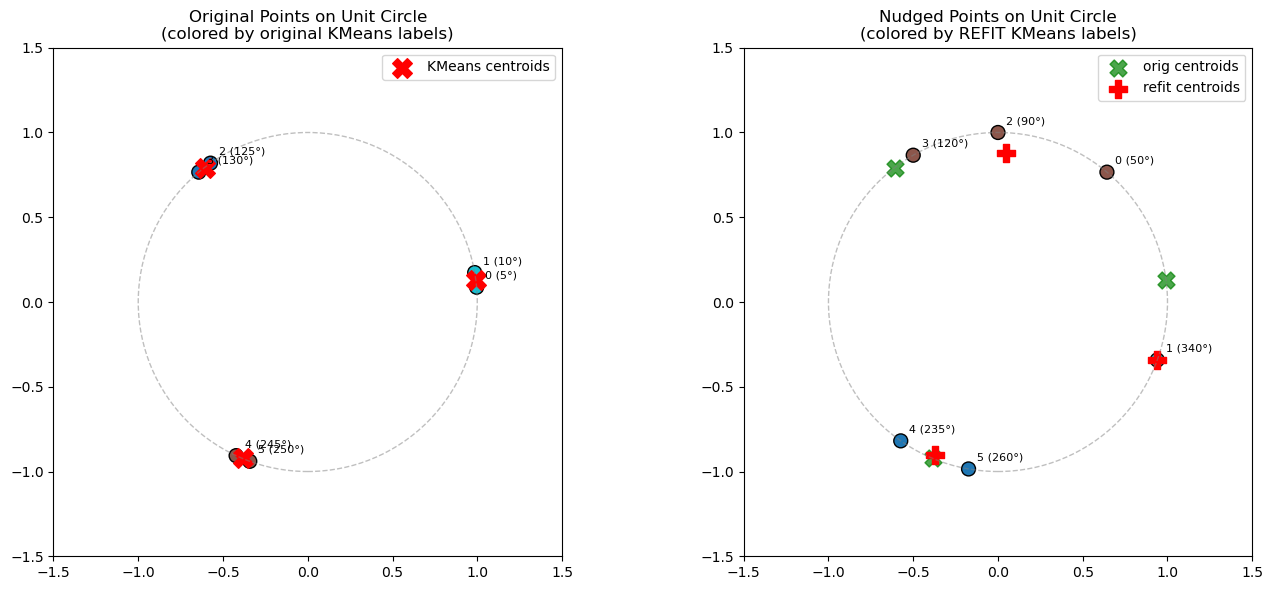

COMPARISON: Per-sample stability vs Partition similarity
Per-sample match (nudged predicted by orig centroids): 100.00%
Adjusted Rand Index (orig labels vs refit labels):     0.4444
Jaccard Index (same-cluster pairs):                    0.4000

Original angles:  [  5  10 125 130 245 250]
Nudged angles:    [ 50 340  90 120 235 260]

Original labels:  [2 2 0 0 1 1]
Refit labels:     [1 2 1 1 0 0]

✓ DEMONSTRATED: High per-sample stability but different partition!
  This proves the two measures are NOT equivalent.


In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from itertools import combinations

# ============================================================
# MANUALLY ENTER ANGLES FOR EACH POINT (in degrees)
# ============================================================
# Original points (6 points, indices 0-5)
angles_orig = np.array([
    5,    # point 0
    10,   # point 1
    125,  # point 2
    130,  # point 3
    245,  # point 4
    250,  # point 5
])

# Nudged points (6 points, indices 0-5)
angles_nudged = np.array([
    50,   # point 0
    340,    # point 1
    90,  # point 2
    120,  # point 3
    235,  # point 4
    260,  # point 5
])
# ============================================================

# Convert to cartesian (all points have radius=1)
points = np.column_stack([np.cos(np.deg2rad(angles_orig)), np.sin(np.deg2rad(angles_orig))])
nudged = np.column_stack([np.cos(np.deg2rad(angles_nudged)), np.sin(np.deg2rad(angles_nudged))])

# Fit KMeans on original points
kmeans_orig = KMeans(n_clusters=3, random_state=0, n_init=10).fit(points)
labels_orig = kmeans_orig.labels_
orig_centers = kmeans_orig.cluster_centers_

# Verify: each nudged point is still closest to its original centroid
dists_to_orig = np.linalg.norm(nudged[:, None, :] - orig_centers[None, :, :], axis=2)
pred_against_orig = np.argmin(dists_to_orig, axis=1)
per_sample_match = np.mean(pred_against_orig == labels_orig)

# Refit KMeans on nudged points
kmeans_nudged = KMeans(n_clusters=3, random_state=0, n_init=10).fit(nudged)
labels_refit = kmeans_nudged.labels_
new_centers = kmeans_nudged.cluster_centers_

# Compute metrics
ari = adjusted_rand_score(labels_orig, labels_refit)

def same_pairs(labels):
    pairs = set()
    for i, j in combinations(range(len(labels)), 2):
        if labels[i] == labels[j]:
            pairs.add((i, j))
    return pairs

pairs_orig = same_pairs(labels_orig)
pairs_refit = same_pairs(labels_refit)
if len(pairs_orig | pairs_refit) > 0:
    jaccard = len(pairs_orig & pairs_refit) / len(pairs_orig | pairs_refit)
else:
    jaccard = 1.0

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Original points
axs[0].scatter(points[:, 0], points[:, 1], c=labels_orig, cmap='tab10', s=100, edgecolors='k')
axs[0].scatter(orig_centers[:, 0], orig_centers[:, 1], marker='X', c='red', s=200, label='KMeans centroids')
for i in range(len(points)):
    axs[0].annotate(f"{i} ({angles_orig[i]}°)", (points[i, 0] + 0.05, points[i, 1] + 0.05), fontsize=8)
axs[0].set_title(f"Original Points on Unit Circle\n(colored by original KMeans labels)")
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_ylim(-1.5, 1.5)
axs[0].set_aspect('equal')
axs[0].legend()
circle = plt.Circle((0, 0), 1.0, color='gray', fill=False, linestyle='--', alpha=0.5)
axs[0].add_artist(circle)

# Nudged points
axs[1].scatter(nudged[:, 0], nudged[:, 1], c=labels_refit, cmap='tab10', s=100, edgecolors='k')
axs[1].scatter(orig_centers[:, 0], orig_centers[:, 1], marker='X', c='green', s=150, label='orig centroids', alpha=0.7)
axs[1].scatter(new_centers[:, 0], new_centers[:, 1], marker='P', c='red', s=150, label='refit centroids')
for i in range(len(nudged)):
    axs[1].annotate(f"{i} ({angles_nudged[i]}°)", (nudged[i, 0] + 0.05, nudged[i, 1] + 0.05), fontsize=8)
axs[1].set_title(f"Nudged Points on Unit Circle\n(colored by REFIT KMeans labels)")
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_ylim(-1.5, 1.5)
axs[1].set_aspect('equal')
axs[1].legend()
circle2 = plt.Circle((0, 0), 1.0, color='gray', fill=False, linestyle='--', alpha=0.5)
axs[1].add_artist(circle2)

plt.tight_layout()
plt.show()

# Print metrics
print("=" * 60)
print("COMPARISON: Per-sample stability vs Partition similarity")
print("=" * 60)
print(f"Per-sample match (nudged predicted by orig centroids): {per_sample_match:.2%}")
print(f"Adjusted Rand Index (orig labels vs refit labels):     {ari:.4f}")
print(f"Jaccard Index (same-cluster pairs):                    {jaccard:.4f}")
print()
print("Original angles: ", angles_orig)
print("Nudged angles:   ", angles_nudged)
print()
print("Original labels: ", labels_orig)
print("Refit labels:    ", labels_refit)
print()
if per_sample_match > 0.9 and ari < 1.0:
    print("✓ DEMONSTRATED: High per-sample stability but different partition!")
    print("  This proves the two measures are NOT equivalent.")
else:
    print(f"Note: Per-sample match={per_sample_match:.2%}, ARI={ari:.4f}")